Predicting Price Moves with News Sentiment

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mukit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sample problem dates:
10    2020-05-22 00:00:00
11    2020-05-22 00:00:00
12    2020-05-21 00:00:00
13    2020-05-21 00:00:00
14    2020-05-21 00:00:00
Name: date, dtype: object


C:\Users\mukit\AppData\Local\Temp\ipykernel_10428\3033604162.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dates = dates.fillna(new_dates)
C:\Users\mukit\AppData\Local\Temp\ipykernel_10428\3033604162.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dates = dates.fillna(new_dates)
C:\Users\mukit\AppData\Local\Temp\ipykernel_10428\3033604162.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future beha

📊 Same-day correlation: r = nan, p = nan
📈 Next-day correlation: r = nan, p = nan


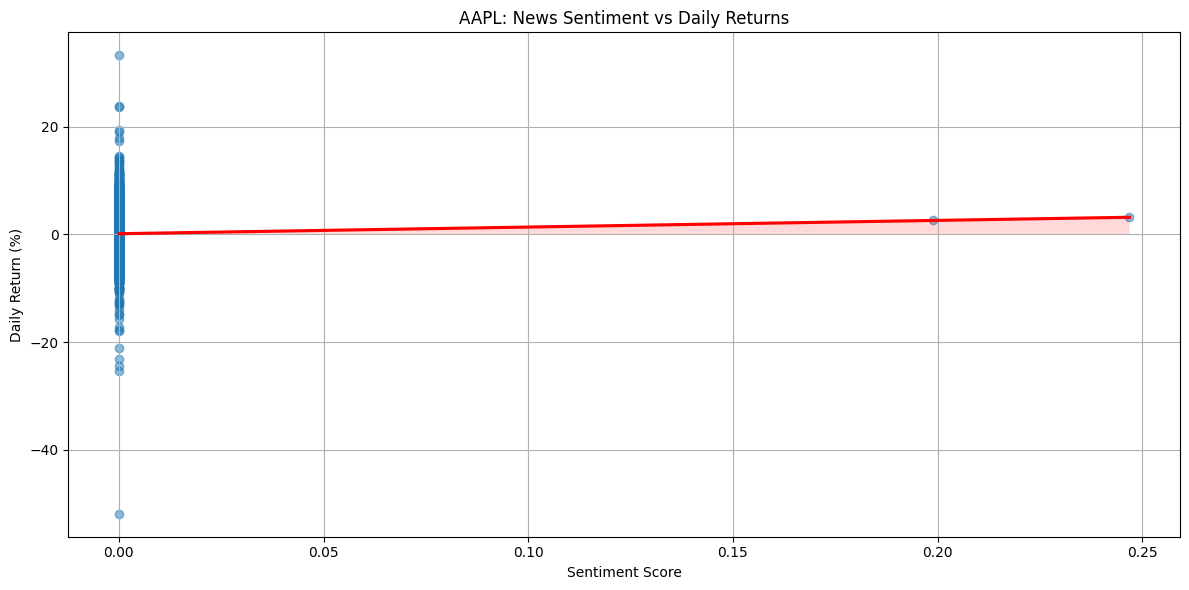

In [6]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob  # Optional for enhancement
from datetime import datetime, date
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('vader_lexicon')

# ================================
# 1. Safe Date Parser Function
# ================================
def safe_date_parse(date_series):
    """Convert a series to datetime with extensive error handling."""
    dates = pd.to_datetime(date_series, errors='coerce')
    if dates.isna().any():
        print(f"Warning: {dates.isna().sum()} dates couldn't be parsed.")
        print("Sample problem dates:")
        print(date_series[dates.isna()].head())
        for fmt in ['%m/%d/%Y', '%d-%m-%Y', '%Y%m%d', '%b %d %Y', '%d %b %Y']:
            try:
                new_dates = pd.to_datetime(date_series, format=fmt, errors='coerce')
                dates = dates.fillna(new_dates)
            except:
                continue
    return dates

# ================================
# 2. Load News Data
# ================================
news_path = r"C:\Users\mukit\Desktop\Kify AIML\Code Part\Week 1\-Predicting-Price-Moves-with-News-Sentiment\Data\raw_analyst_ratings\raw_analyst_ratings.csv"
news_df = pd.read_csv(news_path)
news_df.columns = [col.lower() for col in news_df.columns]
news_df['date'] = safe_date_parse(news_df['date'])
news_df = news_df.dropna(subset=['date'])

# Filter for AAPL news
aapl_news = news_df[news_df['stock'].str.upper() == 'AAPL'][['date', 'headline', 'stock']].copy()

# Ensure datetime with timezone
aapl_news['date'] = pd.to_datetime(aapl_news['date'])
if aapl_news['date'].dt.tz is None:
    aapl_news['date'] = aapl_news['date'].dt.tz_localize('America/New_York')

# ================================
# 3. Sentiment Analysis (VADER)
# ================================
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isna(text):
        return 0
    return sid.polarity_scores(str(text))['compound']

aapl_news['sentiment_score'] = aapl_news['headline'].apply(get_sentiment)
aapl_news['sentiment_label'] = np.where(
    aapl_news['sentiment_score'] > 0.1, 'positive',
    np.where(aapl_news['sentiment_score'] < -0.1, 'negative', 'neutral')
)

# ================================
# 4. Load Stock Price Data
# ================================
stock_path = r"C:\Users\mukit\Desktop\Kify AIML\Code Part\Week 1\-Predicting-Price-Moves-with-News-Sentiment\Data\yfinance_data\yfinance_data\AAPL_historical_data.csv"
aapl_stock = pd.read_csv(stock_path)
aapl_stock = aapl_stock.rename(columns={'Date': 'date', 'Close': 'close', 'Adj Close': 'adj_close'})
aapl_stock['date'] = safe_date_parse(aapl_stock['date'])
aapl_stock = aapl_stock.dropna(subset=['date'])
aapl_stock = aapl_stock.sort_values('date')

# ================================
# 5. Calculate Daily Returns
# ================================
aapl_stock['daily_return_pct'] = aapl_stock['close'].pct_change() * 100

# ================================
# 6. Align Dates and Merge
# ================================
aapl_news['date_only'] = aapl_news['date'].dt.date
aapl_stock['date_only'] = aapl_stock['date'].dt.date

merged_df = pd.merge(
    aapl_stock,
    aapl_news.groupby('date_only')['sentiment_score'].mean().reset_index(),
    on='date_only',
    how='left'
)

# Fill missing sentiment with neutral (0)
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0)

# ================================
# 7. Correlation Analysis
# ================================
# Same-day
r_same, p_same = pearsonr(merged_df['sentiment_score'], merged_df['daily_return_pct'])

# Next-day
merged_df['next_day_return'] = merged_df['daily_return_pct'].shift(-1)
r_next, p_next = pearsonr(merged_df['sentiment_score'], merged_df['next_day_return'])

print(f"📊 Same-day correlation: r = {r_same:.3f}, p = {p_same:.4f}")
print(f"📈 Next-day correlation: r = {r_next:.3f}, p = {p_next:.4f}")

# ================================
# 8. Visualization
# ================================
plt.figure(figsize=(12, 6))
sns.regplot(
    data=merged_df,
    x='sentiment_score',
    y='daily_return_pct',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)
plt.title("AAPL: News Sentiment vs Daily Returns")
plt.xlabel("Sentiment Score")
plt.ylabel("Daily Return (%)")
plt.grid(True)
plt.tight_layout()
plt.show()
